# Compare 2D cloud size distributions to 3D plume distributions.  

2019-10: Goal is to find out if the scaling of clouds and convective plumes relate to each other. 

## Functions to cluster 2D cloud fields with periodic boundary conditions and get the size distribution


Steps:
0. Use "cdo vertmax inputfile outputfile" to get the maxvalue of cloud liquid water in each vertical column (ql_vertmax, hab ich schon gemacht, ist in deinem offentlich ordner).
1. Load the files
2. Convert to binary files of zero or 1. If max value greater than 1e-6 kg/kg count as cloud. 
3. Get labels using cluster_2D, which is the same stuff you have used before but works with periodic boundary conditions
4. Calculate CSD with same tools used previously

## Get plume size distribution from pandas file.  

I calculate the plume properties beforehand and give them to you. The tricky part is slecting the plumes from the right time, so I added some cells showing how it is done. You still have to calculate the the size distribution though.  


# Tasks

1. Work through the cells, try to understand everything. 
2. Select a single time output which has clouds, calculate slope of distribution.
3. Make a loop that calculates the slopes of the cloud size distribution over the day. Is there a daily cycle? 
4. Repeat 2 and 3 with plume size distribution
5. Compare slope of plumes vs 2d clouds. 


# Questions


In [1]:
## Functions and packeges

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndi
from random import random
import matplotlib
from netCDF4 import Dataset
from helper_functions import *
import sys

import pandas as pd

In [2]:
colors = [(0.5,0.5,0.5)] + [(random(),random(),random()) for i in range(1000)]
random_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('random_cmap', colors, N=1000)

In [3]:

def add_buffer(A,n_extra):
    """Adds n_extra cells/columns in x and y direction to array A. Works with 2d and 3d arrays, super advanced stuff right here. """
    if A.ndim == 2:
        A_extra = np.vstack([A[-n_extra:,:],A,A[:n_extra,:]])
        A_extra = np.hstack([A_extra[:,-n_extra:],A_extra,A_extra[:,:n_extra]])
    if A.ndim == 3:
        A_extra = np.concatenate((A[:,-n_extra:,:],A,A[:,:n_extra,:]),axis=1)
        A_extra = np.concatenate((A_extra[:,:,-n_extra:],A_extra,A_extra[:,:,:n_extra]),axis=2)
        
    
    return A_extra
 



In [4]:

def cluster_2D(A,buffer_size=30 ):
    """
    For Lennéa, isn't pretty. 
    
    Uses inefficient np.where, but should be fine for 2D
    
    A is 2D matrix of 1 (cloud) and 0 (no cloud)
    buffer_size is the percentile added to each side to deal with periodic boundary domains
    
    returns labeled_clouds, is 0 where no cloud
    """
    #Uses a default periodic boundary domain
    n_max = A.shape[0]
 
    n_buffer = int(buffer_size/100.*n_max)

    #Explanding c and w fields with a buffer on each edge to take periodic boundaries into account. 
    A_buf=add_buffer(A,n_buffer)
    
    #labeled_clouds  = np.zeros_like(A_buf)
    
    #This is already very impressive, ndi.label detects all areas with marker =1 that are connected and gives each resulting cluster an individual integer value 
    labeled_clouds,n_clouds  = ndi.label(A_buf)
    
    
    
    #Going back from the padded field back to the original size
    # OK, calculate index means, then only look at those with a mean inside the original box
    # We ignore the cells with the mean outside, they will be cut off or overwritten
    # For those inside we check if they have something outside original box, and if so a very ugly hard coded overwritting is done. 
    # In the very end the segmentation box is cut back down to the original size

    
    
    
    #fancy quick sorting. 
    unique_labels, unique_label_counts = np.unique(labeled_clouds,return_counts=True)
    lin_idx       = np.argsort(labeled_clouds.ravel(), kind='mergesort')
    lin_idx_split = np.split(lin_idx, np.cumsum(np.bincount(labeled_clouds.ravel())[:-1]))
    
    for c in range(1,n_clouds+1): 
        idx_x,idx_y = np.unravel_index(lin_idx_split[c],labeled_clouds.shape)
    
    

        #idx_x,idx_y = np.where(labeled_clouds==c)
        idx_x_m = np.mean(idx_x)
        idx_y_m = np.mean(idx_y)

        if idx_x_m< n_buffer or idx_x_m>n_buffer+n_max or idx_y_m< n_buffer or idx_y_m>n_buffer+n_max:
            #cluster is outside, chuck it
            #print(c,'cluster out of bounds',idx_x,idx_y)
            #segmentation_cp[segmentation==c] = 0
            bla = 1

        else:
            idx_x_max = np.max(idx_x)
            idx_x_min = np.min(idx_x)
            idx_y_min = np.min(idx_y)
            idx_y_max = np.max(idx_y)
            if idx_x_min< n_buffer or idx_x_max>n_buffer+n_max or idx_y_min< n_buffer or idx_y_max>n_buffer+n_max:
                #print(c,'this is our guniea pig')
                if idx_x_min<n_buffer:
                    idx_x_sel = idx_x[idx_x<n_buffer]+n_max
                    idx_y_sel = idx_y[idx_x<n_buffer]
                    labeled_clouds[idx_x_sel,idx_y_sel] = c
                if idx_x_max>=n_buffer+n_max:
                    idx_x_sel = idx_x[idx_x>=n_buffer+n_max]-n_max
                    idx_y_sel = idx_y[idx_x>=n_buffer+n_max]
                    labeled_clouds[idx_x_sel,idx_y_sel] = c
                if idx_y_min<n_buffer:
                    idx_x_sel = idx_x[idx_y<n_buffer]
                    idx_y_sel = idx_y[idx_y<n_buffer]+n_max
                    labeled_clouds[idx_x_sel,idx_y_sel] = c
                if idx_y_max>=n_buffer+n_max:
                    idx_x_sel = idx_x[idx_y>=n_buffer+n_max]
                    idx_y_sel = idx_y[idx_y>=n_buffer+n_max]-n_max
                    labeled_clouds[idx_x_sel,idx_y_sel] = c



    #Now cut to the original domain
    labeled_clouds_orig = labeled_clouds[n_buffer:-n_buffer,n_buffer:-n_buffer]
    
    #And to clean up the missing labels 
    def sort_and_tidy_labels_2D(segmentation):
        """
        For a given 2D integer array sort_and_tidy_labels will renumber the array 
        so no gaps are between the the integer values and replace them beginning with 0 upward. 
        Also, the integer values will be sorted according to their frequency. 
        
        1D example: 
        [4,4,1,4,1,4,4,3,3,3,3,4,4]
        -> 
        [0,0,2,0,2,0,0,1,1,1,1,0,0]
        """
       
        unique_labels, unique_label_counts = np.unique(segmentation,return_counts=True)
        n_labels = len(unique_labels)
        unique_labels_sorted = [x for _,x in sorted(zip(unique_label_counts,unique_labels))][::-1]
        new_labels = np.arange(n_labels)
       
        lin_idx       = np.argsort(segmentation.ravel(), kind='mergesort')
        lin_idx_split = np.split(lin_idx, np.cumsum(np.bincount(segmentation.ravel())[:-1]))
        #think that I can now remove lin_idx, as it is an array with the size of the full domain. 
        del(lin_idx)
       
        for l in range(n_labels):
            c = unique_labels[l]
            idx_x,idx_y = np.unravel_index(lin_idx_split[c],segmentation.shape)
            segmentation[idx_x,idx_y] = new_labels[l]
       
        return segmentation 
    

    labeled_clouds_clean = sort_and_tidy_labels_2D(labeled_clouds_orig)
    
    
    return labeled_clouds_clean



    

# Ok, 2D test clustering test 

In [5]:
from netCDF4 import Dataset
file_ql = '/data/testbed/lasso/sims/20160611/ql_vertmax.nc'
data_ql = Dataset(file_ql)
timestep = 12
l2D = data_ql.variables['ql'][timestep,:,:]

l2D_bi = np.zeros_like(l2D).astype(int)

l2D_bi[l2D>1e-6]=1



In [6]:
labeled_clouds = cluster_2D(l2D_bi,buffer_size=20)

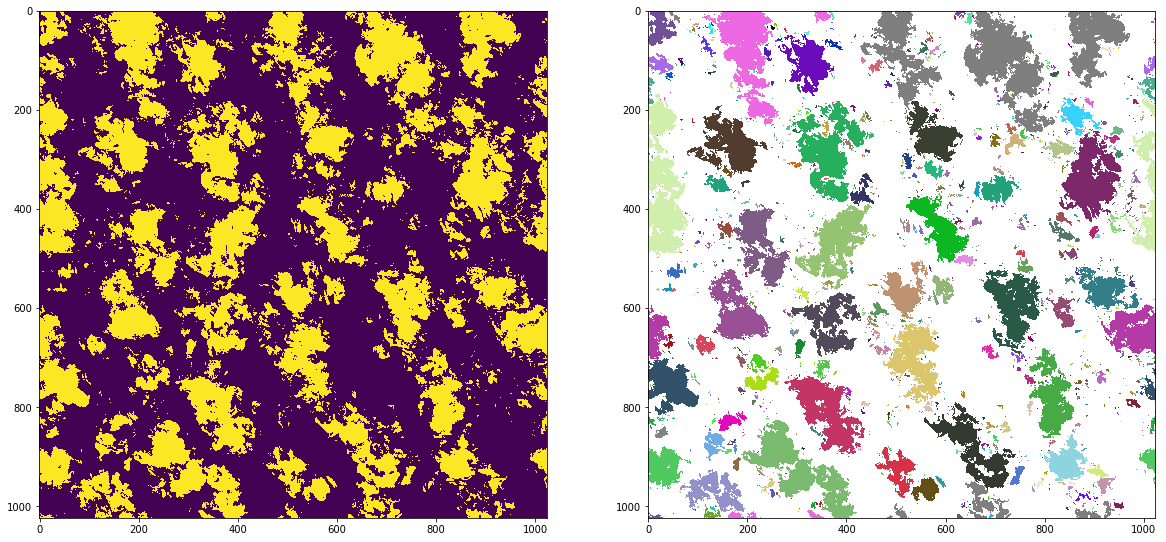

In [7]:
masked_clouds = np.ma.masked_where(labeled_clouds<1,labeled_clouds)
fig,ax = plt.subplots(1,2,figsize=(20,10))
im1  =ax[0].imshow(l2D_bi)
#im1  =ax[1].imshow(labeled_clouds,cmap=random_cmap)
im1  =ax[1].imshow(masked_clouds,cmap=random_cmap)



[21017.59679412  3672.44809357  2636.52233065 ...    43.30127019
    25.            25.        ]


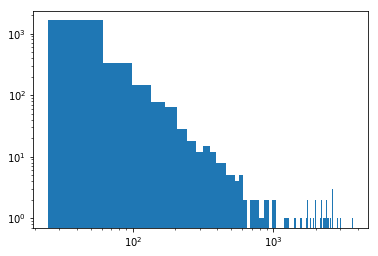

In [8]:
labeled_clouds = cluster_2D(l2D_bi,buffer_size=20)

#Grosse jeder wolken
label, cl_pixels = np.unique(labeled_clouds.ravel(),return_counts=True)
cl_size = np.sqrt(cl_pixels*25.*25.)
#print(cl_pixels)
print(cl_size)

#Nicht vergessen, erster cluster ist keine wolke, deshalb von :1
plt.hist(cl_size[1:],bins=100)
plt.yscale('log')
plt.xscale('log')

In [9]:
# cloud_size supposed to be cl_size[1:]

from netCDF4 import Dataset
file_ql = '/data/testbed/lasso/sims/20160611/ql_vertmax.nc'
data_ql = Dataset(file_ql)
time = data_ql.variables['time'][:]
time_unraveled = time.ravel()
slope = []
time_nozeros = []
time_hack = np.arange(time.size)/2.+6.

for k in range(time.size):
    #timestep = time_unraveled.index[i]
    l2D = data_ql.variables['ql'][k,:,:]

    l2D_bi = np.zeros_like(l2D).astype(int)

    l2D_bi[l2D>1e-6]=1
    labeled_clouds = cluster_2D(l2D_bi,buffer_size=20)

    #Grosse jeder wolken
    label, cl_pixels = np.unique(labeled_clouds.ravel(),return_counts=True)
    
    if (len(cl_pixels)>1):
        cl_size = np.sqrt(cl_pixels*25.*25.)
        bins_log_mm, ind, CSD = log_binner_minmax(cl_size[1:],1,300,100)
        x_bins_log_mm = bins_log_mm[:-1]/2.+bins_log_mm[1:]/2.
               
        j = 0
        global_j = 0
        global_i = 0
        for i in range(CSD.size):
            j += 1
            if math.isnan(CSD[i]):
                  j = 0
            elif j > global_j:
                global_j = j
                global_i = i     
        if (len(x_bins_log_mm[global_i-global_j+1:global_i+1])==0):
            continue
        else:
            m2,b2 = np.polyfit(np.log(x_bins_log_mm[global_i-global_j+1:global_i+1]),np.log(CSD[global_i-global_j+1:global_i+1]), 1)
            f2 = 10**(m2*np.log10(x_bins_log_mm))*np.exp(b2)
            slope.append(m2)
            time_nozeros.append(time_hack[k])
    else: 
        k = k+1
print(slope) 
print(time_nozeros)

[-3.116859699003526, -2.6849917666275203, -2.111796002478875, -2.729643467175499, -2.499677112850567, -2.3518013097167625, -2.4624114056531328, -2.518877920147158, -2.419949971256345, -2.622917067261609, -2.5855582103045913, -2.781485695764497, -2.640652182970043, -2.469146711964689, -2.8437968511010787, -2.4619393315510907, -2.4151602347616086, -2.412922763468142, -2.6095525334137037]
[9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0, 15.5, 16.0, 16.5, 17.0, 17.5, 18.0]


In [12]:
import seaborn as sns
sns.set()

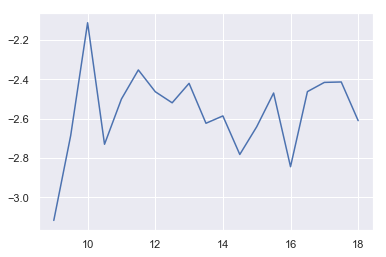

In [13]:
plt.plot(time_nozeros,slope)

-2.6095525334137037


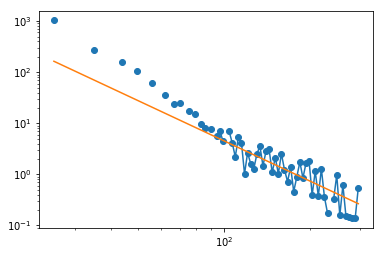

In [126]:
bins_log_mm, ind, CSD = log_binner_minmax(cl_size[1:],1,300,100)
x_bins_log_mm = bins_log_mm[:-1]/2.+bins_log_mm[1:]/2.
x_mm_nozeros = []
CSD_nozeros = []
for i in range(CSD.size):
    if math.isnan(CSD[i]):
            CSD_nozeros.append(CSD[i])
            x_mm_nozeros.append(x_bins_log_mm[i])            
j = 0
global_j = 0
global_i = 0
for i in range(CSD.size):
    j += 1
    if math.isnan(CSD[i]):
        j = 0
    elif j > global_j:
        global_j = j
        global_i = i
CSD[global_i-global_j+1:global_i+1]

m2,b2 = np.polyfit(np.log(x_bins_log_mm[global_i-global_j+1:global_i+1]),np.log(CSD[global_i-global_j+1:global_i+1]), 1)
f2 = 10**(m2*np.log10(x_bins_log_mm))*np.exp(b2)
print(m2)    
plt.plot(x_bins_log_mm,CSD,'-o')
plt.plot(x_bins_log_mm,f2)
plt.xscale('log')
plt.yscale('log')

n: 1607
815
-1.2275357532093079


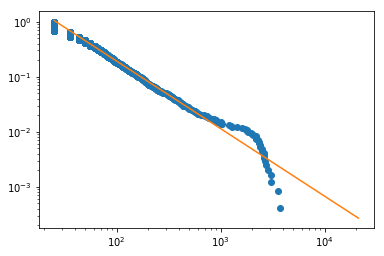

In [45]:
N_samples = len(cl_size)
x_min_pl = 35
dist_sort = np.sort(cl_size)
dist_sort = dist_sort[::-1]
p = np.array(range(N_samples))/float(N_samples)
#calculate slope (alpha)
alpha = alpha_newman5(cl_size,cloud_size_min=x_min_pl)
x_min_shade3 = np.min(dist_sort)
x_max_shade3 = x_min_pl

#calculate y-intercept of linear equation with alpha-1
def powerlaw_func(x,alpha,C):
    return C*x**-alpha
def cumulative_dist_func(x,alpha,C):
    return C/(alpha-1)*x**-(alpha-1)

#reverse p and dist_sort so they go from smallest to biggest and first index for which powerlaw holds
dist_sort_rev = dist_sort[::-1]
p_rev = p[::-1]
first_idx = np.where(dist_sort_rev>x_min_pl)[0][0]
print(first_idx)

sum_cum_dist = np.sum(p_rev[first_idx:]*(dist_sort_rev[first_idx:]-dist_sort_rev[first_idx-1:-1]))
#integrate powerlaw of alpha-1 with sum over all values
integral_powerlaw = np.sum(powerlaw_func(dist_sort_rev[first_idx:],alpha-1,1)*(dist_sort_rev[first_idx:]-dist_sort_rev[first_idx-1:-1]))

b4 = (alpha-1)*sum_cum_dist/integral_powerlaw
f3 = cumulative_dist_func(dist_sort,alpha,b4)
m3 = -alpha+1
print(m3)

plt.plot(dist_sort,p, 'o')
plt.plot(dist_sort,f3)
plt.xscale('log')
plt.yscale('log')

In [9]:
from importlib import reload
import helper_functions
reload(helper_functions)
from helper_functions import *

# Loading and working with pandas data 

In [14]:
#load the plume data
#this "pandas" file contains all the plumes over the whole day with their properties
filename_couv_20160611_cf2_mf       = '/data/testbed/lasso/clustering/prop_20160611_c_mask_100c_mark_200_cf2_mf1.pkl'
prop_plumes    = pd.read_pickle(filename_couv_20160611_cf2_mf)


In [15]:
#hier mal zeigen was alles an infos ist
prop_plumes.columns

Index(['Volume', 'sq Area', 'Radius', 'Area', 'height', 'V_h', 'w',
       'w profile', 'ql profile', 'qv profile', 'Area profile', 'couv profile',
       'wet h', 'wet A', 'wet V', 'wet w', 'dry h', 'dry A', 'dry V', 'dry w',
       'time', 'x', 'y', 'z', 'base', 'z max cf', 'w flux', 'qt flux',
       'qt total flux', 'qt fluc'],
      dtype='object')

In [16]:
#einfach mal zeigen.
prop_plumes

,Volume,sq Area,Radius,Area,height,V_h,w,w profile,ql profile,qv profile,...,time,x,y,z,base,z max cf,w flux,qt flux,qt total flux,qt fluc
0,16112.844594,25600.000000,14443.253339,655360000.0,6400.0,25566.327074,-0.000006,"[0.0, -0.00032491926685906947, -0.000398317002...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.014273595064878464, 0.014154225587844849, 0...",...,2020-01-01 06:30:00,0,0,0,0.0,3.0,"[0.0, -185060.81455770982, -226476.57507899567...","[0.0, 7.40488170780651e-10, 7.339970298225751e...","[0.0, -2619.006004361779, -3188.999716712715, ...","[-2.0582228899002075e-07, -1.909211277961731e-..."
1,470.619938,954.921463,538.756742,911875.0,200.0,721.922347,0.002163,"[0.0, 0.0018148589879274368, 0.002322709420695...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, ...","[0.014275566674768925, 0.014155998826026917, 0...",...,2020-01-01 06:30:00,100,809,3,0.0,3.0,"[0.0, 1244.3126935977489, 1727.5151316425763, ...","[0.0, 3.185189223486873e-09, 3.538914272738225...","[0.0, 17.614704141806214, 24.33082686366106, 2...","[1.7657876014709473e-06, 1.582317054271698e-06..."
2,444.585314,1007.161854,568.230227,1014375.0,200.0,662.853679,0.002055,"[0.0, 0.0018141501350328326, 0.002371067181229...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, ...","[0.014275024645030499, 0.014155501499772072, 0...",...,2020-01-01 06:30:00,741,470,3,0.0,3.0,"[0.0, 1188.2683384465054, 1624.18101914227, 16...","[0.0, 1.9812382845429966e-09, 2.28092011944625...","[0.0, 16.820542614368605, 22.874526603118284, ...","[1.2237578630447388e-06, 1.0849907994270325e-0..."
3,412.220502,847.053717,477.898884,717500.0,200.0,591.806028,0.002470,"[0.0, 0.0024160246830433607, 0.002946735825389...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, ...","[0.01427534595131874, 0.014155798591673374, 0....",...,2020-01-01 06:30:00,314,605,3,0.0,3.0,"[0.0, 1206.5023260947783, 1594.9207654921338, ...","[0.0, 3.6329041996907563e-09, 3.79320796994875...","[0.0, 17.079151089092193, 22.462951801571762, ...","[1.5450641512870789e-06, 1.3820827007293701e-0..."
4,411.206539,823.103882,464.386636,677500.0,200.0,589.623821,0.002612,"[0.0, 0.0025975152384489775, 0.003235554089769...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, ...","[0.014275557361543179, 0.01415596716105938, 0....",...,2020-01-01 06:30:00,226,70,3,0.0,3.0,"[0.0, 1306.8748543446418, 1769.4436428428162, ...","[0.0, 4.648934126549875e-09, 4.77867834192125e...","[0.0, 18.50039012651905, 24.921274359712697, 2...","[1.7564743757247925e-06, 1.5506520867347717e-0..."
5,401.427193,796.084166,449.142394,633750.0,200.0,568.715658,0.002405,"[0.0, 0.002236604690551758, 0.0028520929627120...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, ...","[0.014275345019996166, 0.014155803248286247, 0...",...,2020-01-01 06:30:00,435,598,2,0.0,3.0,"[0.0, 1065.1829838752747, 1374.3522964068688, ...","[0.0, 3.3129288201649842e-09, 3.69680330791766...","[0.0, 15.078621572683915, 19.356463794792944, ...","[1.5441328287124634e-06, 1.3867393136024475e-0..."
6,390.532912,736.970149,415.790881,543125.0,200.0,545.721999,0.002557,"[0.0, 0.0029780592303723097, 0.003760117571800...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, ...","[0.014275804162025452, 0.014156175777316093, 0...",...,2020-01-01 06:30:00,594,920,0,0.0,3.0,"[0.0, 1416.4394214458298, 1750.804744369816, 1...","[0.0, 5.756211063356886e-09, 6.116168904668484...","[0.0, 20.05161192300875, 24.659020698436507, 1...","[2.0032748579978943e-06, 1.759268343448639e-06..."
7,379.682040,717.199414,404.636439,514375.0,175.0,559.256522,0.002092,"[0.0, 0.0023407055996358395, 0.002802875591441...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan, ...","[0.01427560392767191, 0.014155983924865723, 0....",...,2020-01-01 06:30:00,595,876,2,0.0,3.0,"[0.0, 952.3745908518322, 1198.2293153414503, 1...","[0.0, 4.1486738489027175e-09, 4.14969836270984...","[0.0, 13.481994890298665, 16.87615756964078, 1...","[1.8030405044555664e-06, 1.5674158930778503e-0..."
8,379.066847,854.766050,482.250102,730625.0

In [17]:
#Since you only need time and area we will get rid of the rest
plumes_time_area = prop_plumes[['time','sq Area']]
del(prop_plumes)

In [18]:
plumes_time_area

,time,sq Area
0,2020-01-01 06:30:00,25600.000000
1,2020-01-01 06:30:00,954.921463
2,2020-01-01 06:30:00,1007.161854
3,2020-01-01 06:30:00,847.053717
4,2020-01-01 06:30:00,823.103882
5,2020-01-01 06:30:00,796.084166
6,2020-01-01 06:30:00,736.970149
7,2020-01-01 06:30:00,717.199414
8,2020-01-01 06:30:00,854.766050
9,2020-01-01 06:30:00,820.060973


In [19]:
#For each timestep there is a giant plume with a sq Area of 25600, this is actually not a plume but everywhere without a plume, so lets get rid of those
plumes_time_area = plumes_time_area.loc[plumes_time_area['sq Area']<25600]

In [20]:
plumes_time_area

,time,sq Area
1,2020-01-01 06:30:00,954.921463
2,2020-01-01 06:30:00,1007.161854
3,2020-01-01 06:30:00,847.053717
4,2020-01-01 06:30:00,823.103882
5,2020-01-01 06:30:00,796.084166
6,2020-01-01 06:30:00,736.970149
7,2020-01-01 06:30:00,717.199414
8,2020-01-01 06:30:00,854.766050
9,2020-01-01 06:30:00,820.060973
10,2020-01-01 06:30:00,705.779711


In [21]:
#Now you have to find the right timeoutput, watch out that the first timestep 0 in the ql_vertmax file is 6:00 and increases in 30 minute steps, 
#while the first time in plumes_time_area is 6:30  
plume_times = np.unique(plumes_time_area['time'])
print(plume_times)

['2020-01-01T06:30:00.000000000' '2020-01-01T07:00:00.000000000'
 '2020-01-01T07:30:00.000000000' '2020-01-01T08:00:00.000000000'
 '2020-01-01T08:30:00.000000000' '2020-01-01T09:00:00.000000000'
 '2020-01-01T09:30:00.000000000' '2020-01-01T10:00:00.000000000'
 '2020-01-01T10:30:00.000000000' '2020-01-01T11:00:00.000000000'
 '2020-01-01T11:30:00.000000000' '2020-01-01T12:00:00.000000000'
 '2020-01-01T12:30:00.000000000' '2020-01-01T13:00:00.000000000'
 '2020-01-01T13:30:00.000000000' '2020-01-01T14:00:00.000000000'
 '2020-01-01T14:30:00.000000000' '2020-01-01T15:00:00.000000000'
 '2020-01-01T15:30:00.000000000' '2020-01-01T16:00:00.000000000'
 '2020-01-01T16:30:00.000000000' '2020-01-01T17:00:00.000000000'
 '2020-01-01T17:30:00.000000000' '2020-01-01T18:00:00.000000000']


In [59]:
#Get all plumes for a output timestep
timestep = 12 #12 entspricht 12:00 Uhr, was plume_times[11] ist

plume_time_area_timestep = plumes_time_area.loc[plumes_time_area['time']==plume_times[timestep-1]]



In [23]:
plume_time_area_timestep

,time,sq Area
60265,2020-01-01 12:00:00,3769.781161
60266,2020-01-01 12:00:00,3773.012722
60267,2020-01-01 12:00:00,3914.316671
60268,2020-01-01 12:00:00,3177.853049
60269,2020-01-01 12:00:00,3222.964474
60270,2020-01-01 12:00:00,3032.634993
60271,2020-01-01 12:00:00,2887.472944
60272,2020-01-01 12:00:00,3004.683844
60273,2020-01-01 12:00:00,3086.158615
60274,2020-01-01 12:00:00,2724.885319


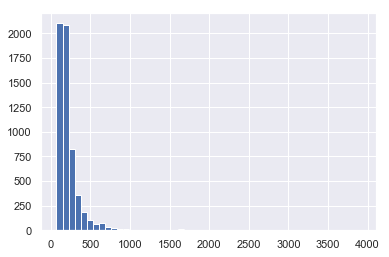

In [32]:
#Jetzt kannst du plume_time_area_timestep['sq Area'] in benutzten um weiter zu machen.
plt.hist(plume_time_area_timestep['sq Area'],bins=50);

-2.564018005918504


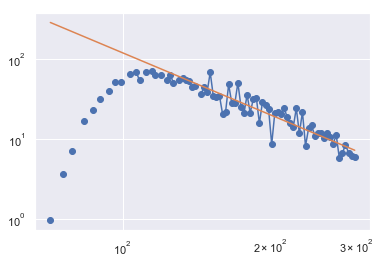

In [35]:
#calculate slope of plumes at timestep 12
bins_log_mm, ind, CSD = log_binner_minmax(plume_time_area_timestep['sq Area'],1,300,100)
x_bins_log_mm = bins_log_mm[:-1]/2.+bins_log_mm[1:]/2.
           
j = 0
global_j = 0
global_i = 0
for i in range(CSD.size):
    j += 1
    if math.isnan(CSD[i]):
        j = 0
    elif j > global_j:
        global_j = j
        global_i = i

m2,b2 = np.polyfit(np.log(x_bins_log_mm[global_i-global_j+1:global_i+1]),np.log(CSD[global_i-global_j+1:global_i+1]), 1)
f2 = 10**(m2*np.log10(x_bins_log_mm))*np.exp(b2)
print(m2)    
plt.plot(x_bins_log_mm,CSD,'-o')
plt.plot(x_bins_log_mm,f2)
plt.xscale('log')
plt.yscale('log')

In [57]:
filename_couv_20160611_cf2_mf       = '/data/testbed/lasso/clustering/prop_20160611_c_mask_100c_mark_200_cf2_mf1.pkl'
prop_plumes    = pd.read_pickle(filename_couv_20160611_cf2_mf)
plumes_time_area = prop_plumes[['time','sq Area']]
del(prop_plumes)
plumes_time_area = plumes_time_area.loc[plumes_time_area['sq Area']<25600]
plume_times = np.unique(plumes_time_area['time'])
timestep = np.arange(time.size)/2.+6.5


for k in range(timestep.size):
    #time_step = timestep[k]
    #print(time_step)
    #print(plumes_time_area['time'])
    #print(plume_times[time_step])
    #same_timestep = []
    #plume_times cant work with time_steps like 6.5(needs to be an integer), needs to find indices that belong to the same timestep
    plume_time_area_timestep = plumes_time_area.loc[plumes_time_area['time']==plume_times[k]]
                                                    
    bins_log_mm, ind, CSD = log_binner_minmax(plume_time_area_timestep,1,300,100)
    x_bins_log_mm = bins_log_mm[:-1]/2.+bins_log_mm[1:]/2.
               
    j = 0
    global_j = 0
    global_i = 0
    for i in range(CSD.size):
        j += 1
        if math.isnan(CSD[i]):
                j = 0
        elif j > global_j:
            global_j = j
            global_i = i     
    if (len(x_bins_log_mm[global_i-global_j+1:global_i+1])==0):
        continue
    else:
        m2,b2 = np.polyfit(np.log(x_bins_log_mm[global_i-global_j+1:global_i+1]),np.log(CSD[global_i-global_j+1:global_i+1]), 1)
        f2 = 10**(m2*np.log10(x_bins_log_mm))*np.exp(b2)
        slope.append(m2)
        time_nozeros.append(timestep[k])    

print(slope) 
print(time_nozeros)
    

6.5
1        2020-01-01 06:30:00
2        2020-01-01 06:30:00
3        2020-01-01 06:30:00
4        2020-01-01 06:30:00
5        2020-01-01 06:30:00
6        2020-01-01 06:30:00
7        2020-01-01 06:30:00
8        2020-01-01 06:30:00
9        2020-01-01 06:30:00
10       2020-01-01 06:30:00
11       2020-01-01 06:30:00
12       2020-01-01 06:30:00
13       2020-01-01 06:30:00
14       2020-01-01 06:30:00
15       2020-01-01 06:30:00
16       2020-01-01 06:30:00
17       2020-01-01 06:30:00
18       2020-01-01 06:30:00
19       2020-01-01 06:30:00
20       2020-01-01 06:30:00
21       2020-01-01 06:30:00
22       2020-01-01 06:30:00
23       2020-01-01 06:30:00
24       2020-01-01 06:30:00
25       2020-01-01 06:30:00
26       2020-01-01 06:30:00
27       2020-01-01 06:30:00
28       2020-01-01 06:30:00
29       2020-01-01 06:30:00
30       2020-01-01 06:30:00
                 ...        
131232   2020-01-01 18:00:00
131233   2020-01-01 18:00:00
131234   2020-01-01 18:00:00
131235   2

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices